# Notebook 02 — Datenvorverarbeitung, Qualitätschecks & Outlier-Handling (Anforderung 4)

**Input:** `data/processed/processed.csv` (aus Notebook 01)  
**Output:** `data/processed/model_ready.csv` + Reports nach `data_derived/` + Plots nach `plots/`

Ziel dieses Notebooks ist eine nachvollziehbare Datenvorverarbeitung für die spätere Modellierung:
- Ableitung zusätzlicher **Qualitätsmerkmale** (z. B. Stop-Zeit, implizite Geschwindigkeit)
- Markierung auffälliger Fälle über **Flags** (regelbasiert + datengetrieben)
- Entscheidung über **Drop vs. Keep** anhand der Ergebnisse (Feedback-Loop)
- Export eines konsistenten, dokumentierten Datensatzes für die Modellierung


## Vorgehen: Mark → Review → Decide (Feedback-Loop)

Um Bias zu vermeiden, werden potenzielle Ausreißer **zunächst nur markiert** und erst nach Sichtung der Ergebnisse entschieden:

1. **Mark:** Regeln/Heuristiken und datengetriebene Grenzen erzeugen Flags
2. **Review:** Anzahl/Beispiele prüfen (inkl. Plausibilität & Datenkontext)
3. **Decide:** Nur klar begründete Fälle entfernen; alles andere bleibt dokumentiert erhalten

Alle Entscheidungen werden in einem **Preprocessing-Report** festgehalten (wie viele Zeilen betroffen sind und warum).


In [10]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

CWD = Path.cwd()
REPO_ROOT = CWD.parent if CWD.name == "notebooks" else CWD

PATH_PROCESSED = REPO_ROOT / "data" / "processed" / "processed.csv"
PATH_MODEL_READY = REPO_ROOT / "data" / "processed" / "model_ready.csv"
PATH_PLOTS = REPO_ROOT / "plots"
PATH_DERIVED = REPO_ROOT / "data_derived"

PATH_PLOTS.mkdir(parents=True, exist_ok=True)
PATH_DERIVED.mkdir(parents=True, exist_ok=True)

def savefig(filename: str) -> None:
    out = PATH_PLOTS / filename
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")

if not PATH_PROCESSED.exists():
    raise FileNotFoundError(f"processed.csv not found at: {PATH_PROCESSED}")

df = pd.read_csv(PATH_PROCESSED)
print("Loaded processed dataset:", df.shape)
df.head()


Loaded processed dataset: (9410, 6)


,distance,elapsed_time,highest_elevation,lowest_elevation,moving_time,total_elevation_gain
0,102977.0,15212,476.6,241.6,14505,968.0
1,64046.5,10964,394.8,221.2,9097,768.0
2,38853.7,5271,68.4,-27.4,5271,162.0
3,39075.8,6634,57.8,-28.2,4813,79.0
4,51232.3,7491,228.6,-10.2,7491,608.0


## Iteration A — Ableitung zusätzlicher Qualitätsmerkmale (noch keine Filterung)

Wir erzeugen abgeleitete Variablen, die Plausibilitätschecks ermöglichen und später für Feature Engineering in Frage kommen:

- `stop_time = elapsed_time - moving_time` (Sekunden)
- `stop_ratio = stop_time / elapsed_time`
- `avg_speed_implied_kmh = distance / moving_time * 3.6` (km/h)
- `pace_min_per_km = (moving_time/60) / (distance/1000)` (min/km)

Wichtig: In dieser Iteration werden Daten **nur markiert und analysiert**, nicht entfernt.


In [11]:
df = df.copy()

# Derived features
df["stop_time"] = df["elapsed_time"] - df["moving_time"]
df["stop_ratio"] = df["stop_time"] / df["elapsed_time"]

# Avoid division by zero: set to NaN where distance or moving_time is 0
df["avg_speed_implied_kmh"] = np.where(
    df["moving_time"] > 0,
    (df["distance"] / df["moving_time"]) * 3.6,   # m/s -> km/h
    np.nan
)

df["pace_min_per_km"] = np.where(
    df["distance"] > 0,
    (df["moving_time"] / 60) / (df["distance"] / 1000),  # min/km
    np.nan
)

# Quick sanity checks
check = pd.DataFrame({
    "n_rows": [len(df)],
    "distance_eq_0": [(df["distance"] == 0).sum()],
    "moving_time_eq_0": [(df["moving_time"] == 0).sum()],
    "elapsed_lt_moving": [(df["elapsed_time"] < df["moving_time"]).sum()],
    "stop_time_negative": [(df["stop_time"] < 0).sum()],
    "stop_time_zero": [(df["stop_time"] == 0).sum()],
})
display(check)

check.to_csv(PATH_DERIVED / "10_quality_quick_checks.csv", index=False)


,n_rows,distance_eq_0,moving_time_eq_0,elapsed_lt_moving,stop_time_negative,stop_time_zero
0,9410,26,0,0,0,1073


,count,mean,std,min,25%,50%,75%,max,median
stop_time,9410.0,968.386079,2398.841141,0.000000,72.250000,257.000000,889.750000,33514.000000,257.000000
stop_ratio,9410.0,0.134727,0.145875,0.000000,0.027672,0.088212,0.194118,0.960437,0.088212
avg_speed_implied_kmh,9410.0,20.627305,4.755507,0.000000,17.916384,20.697691,23.306611,44.922198,20.697691
pace_min_per_km,9384.0,41.411531,3119.953003,1.335643,2.573360,2.897051,3.343741,301611.111111,2.897051


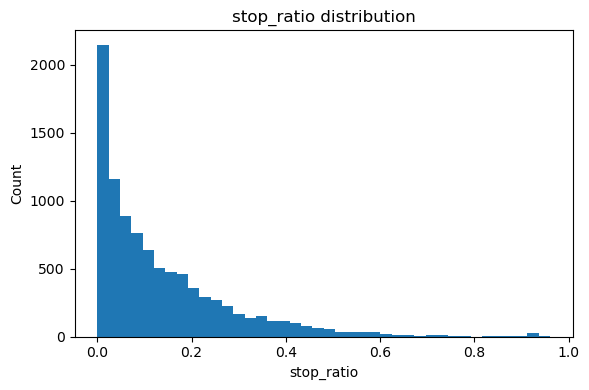

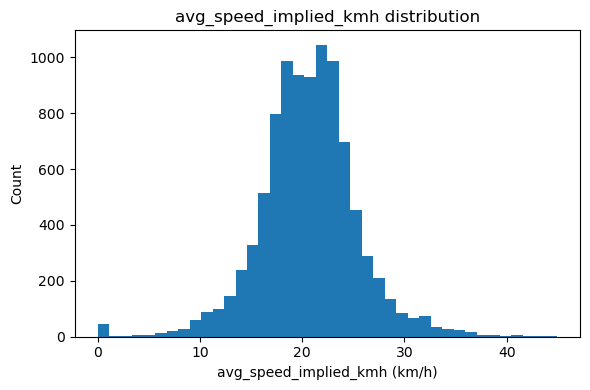

In [12]:
vars_qc = ["stop_time", "stop_ratio", "avg_speed_implied_kmh", "pace_min_per_km"]
desc_qc = df[vars_qc].describe().T
desc_qc["median"] = df[vars_qc].median()
display(desc_qc)

desc_qc.to_csv(PATH_DERIVED / "11_quality_features_describe.csv", index=True)

# Plot: stop_ratio distribution
plt.figure(figsize=(6, 4))
plt.hist(df["stop_ratio"].dropna(), bins=40)
plt.title("stop_ratio distribution")
plt.xlabel("stop_ratio")
plt.ylabel("Count")
savefig("20_stop_ratio_hist.png")
plt.show()

# Plot: implied avg speed distribution
plt.figure(figsize=(6, 4))
plt.hist(df["avg_speed_implied_kmh"].dropna(), bins=40)
plt.title("avg_speed_implied_kmh distribution")
plt.xlabel("avg_speed_implied_kmh (km/h)")
plt.ylabel("Count")
savefig("21_avg_speed_implied_kmh_hist.png")
plt.show()


In [13]:
# Compact stats we need for threshold decisions
key_stats = pd.DataFrame({
    "stop_ratio_min": [df["stop_ratio"].min()],
    "stop_ratio_median": [df["stop_ratio"].median()],
    "stop_ratio_p95": [df["stop_ratio"].quantile(0.95)],
    "stop_ratio_p99": [df["stop_ratio"].quantile(0.99)],
    "stop_ratio_max": [df["stop_ratio"].max()],
    "avg_speed_kmh_min": [df["avg_speed_implied_kmh"].min()],
    "avg_speed_kmh_median": [df["avg_speed_implied_kmh"].median()],
    "avg_speed_kmh_p95": [df["avg_speed_implied_kmh"].quantile(0.95)],
    "avg_speed_kmh_p99": [df["avg_speed_implied_kmh"].quantile(0.99)],
    "avg_speed_kmh_max": [df["avg_speed_implied_kmh"].max()],
    "pace_minpkm_min": [df["pace_min_per_km"].min()],
    "pace_minpkm_median": [df["pace_min_per_km"].median()],
    "pace_minpkm_p95": [df["pace_min_per_km"].quantile(0.95)],
    "pace_minpkm_p99": [df["pace_min_per_km"].quantile(0.99)],
    "pace_minpkm_max": [df["pace_min_per_km"].max()],
})

display(key_stats.round(4))
key_stats.to_csv(PATH_DERIVED / "12_key_stats_quality_features.csv", index=False)


,stop_ratio_min,stop_ratio_median,stop_ratio_p95,stop_ratio_p99,stop_ratio_max,avg_speed_kmh_min,avg_speed_kmh_median,avg_speed_kmh_p95,avg_speed_kmh_p99,avg_speed_kmh_max,pace_minpkm_min,pace_minpkm_median,pace_minpkm_p95,pace_minpkm_p99,pace_minpkm_max
0,0.0,0.0882,0.429,0.6427,0.9604,0.0,20.6977,28.1409,33.311,44.9222,1.3356,2.8971,4.4843,6.7342,301611.1111


In [14]:
qc_counts = pd.DataFrame([{
    "n_rows": len(df),
    "distance_eq_0": int((df["distance"] == 0).sum()),
    "moving_time_eq_0": int((df["moving_time"] == 0).sum()),
    "elapsed_time_eq_0": int((df["elapsed_time"] == 0).sum()),
    "elapsed_lt_moving": int((df["elapsed_time"] < df["moving_time"]).sum()),
    "stop_time_negative": int((df["stop_time"] < 0).sum()),
    "stop_time_zero": int((df["stop_time"] == 0).sum()),
    "stop_ratio_gt_0_5": int((df["stop_ratio"] > 0.5).sum()),
    "stop_ratio_gt_0_8": int((df["stop_ratio"] > 0.8).sum()),
    "avg_speed_gt_50": int((df["avg_speed_implied_kmh"] > 50).sum()),
    "avg_speed_gt_60": int((df["avg_speed_implied_kmh"] > 60).sum()),
}])

display(qc_counts)
qc_counts.to_csv(PATH_DERIVED / "13_qc_counts.csv", index=False)


,n_rows,distance_eq_0,moving_time_eq_0,elapsed_time_eq_0,elapsed_lt_moving,stop_time_negative,stop_time_zero,stop_ratio_gt_0_5,stop_ratio_gt_0_8,avg_speed_gt_50,avg_speed_gt_60
0,9410,26,0,0,0,0,1073,261,40,0,0


## Iteration B — Regel-basierte Flags (Markierung, noch kein Entfernen)

Basierend auf den beobachteten Verteilungen werden auffällige Fälle über Flags markiert.
Wichtig: Ein Flag bedeutet zunächst nur **“prüfen”**, nicht automatisch **“entfernen”**.

Geplante Flags:
- `distance == 0` (führt zu unbrauchbarer Pace/Speed; für Modellierung meist nicht sinnvoll)
- sehr hohe `stop_ratio` (z. B. > 0.8) → ungewöhnlich viel Standzeit
- sehr hohe implizite Durchschnittsgeschwindigkeit (z. B. > 45 km/h) → potenziell unplausibel
- unplausible Pace (extrem groß) → meist Folge von distance≈0


In [15]:
flags = pd.DataFrame(index=df.index)

# Hard plausibility checks (should be 0, but keep for completeness)
flags["flag_elapsed_lt_moving"] = df["elapsed_time"] < df["moving_time"]
flags["flag_stop_time_negative"] = df["stop_time"] < 0

# Data issues / edge cases
flags["flag_distance_eq_0"] = df["distance"] == 0

# Unusual behavior (not necessarily wrong)
flags["flag_stop_ratio_gt_0_8"] = df["stop_ratio"] > 0.8

# Speed plausibility (based on observed max ~44.9 km/h)
flags["flag_avg_speed_gt_45"] = df["avg_speed_implied_kmh"] > 45

# Pace plausibility: extremely large pace indicates distance ~ 0
flags["flag_pace_gt_30"] = df["pace_min_per_km"] > 30  # 30 min/km is extreme for cycling; mainly catches distance->0

flag_counts = flags.sum().sort_values(ascending=False).to_frame("count")
display(flag_counts)

flag_counts.to_csv(PATH_DERIVED / "14_flag_counts_rule_based.csv", index=True)


,count
flag_stop_ratio_gt_0_8,40
flag_distance_eq_0,26
flag_pace_gt_30,22
flag_elapsed_lt_moving,0
flag_stop_time_negative,0
flag_avg_speed_gt_45,0


In [16]:
susp_idx = flags.any(axis=1)
sus = df.loc[susp_idx].copy()

# attach flags for transparency
sus = pd.concat([sus, flags.loc[susp_idx]], axis=1)

print("Suspicious rows (any flag):", len(sus))
display(sus.head(25))

sus.to_csv(PATH_DERIVED / "15_suspicious_cases_rule_based.csv", index=False)


Suspicious rows (any flag): 88


,distance,elapsed_time,highest_elevation,lowest_elevation,moving_time,total_elevation_gain,stop_time,stop_ratio,avg_speed_implied_kmh,pace_min_per_km,flag_elapsed_lt_moving,flag_stop_time_negative,flag_distance_eq_0,flag_stop_ratio_gt_0_8,flag_avg_speed_gt_45,flag_pace_gt_30
2026,74.9,790,190.2,190.2,790,0.0,0,0.000000,0.341316,175.789942,False,False,False,False,False,True
2167,0.0,6520,85.8,79.6,6520,0.0,0,0.000000,0.000000,NaN,False,False,True,False,False,False
2448,0.3,5429,245.6,241.6,5429,0.0,0,0.000000,0.000199,301611.111111,False,False,False,False,False,True
2550,1230.9,3634,239.6,237.6,3634,0.0,0,0.000000,1.219384,49.205189,False,False,False,False,False,True
2692,1196.4,3601,247.0,245.4,3601,0.0,0,0.000000,1.196068,50.164382,False,False,False,False,False,True
2708,0.0,5400,134.4,126.4,5400,0.0,0,0.000000,0.000000,NaN,False,False,True,False,False,False
2920,5145.8,32682,143.6,121.5,1293,47.6,31389,0.960437,14.327053,4.187881,False,False,False,True,False,False
2993,6135.8,12485,128.0,115.0,1987,49.8,10498,0.840849,11.116699,5.397286,False,False,False,True,False,False
4997,11479.7,11140,244.0,107.2,1929,29.0,9211,0.826840,21.424012,2.800596,False,False,False,True,False,False
5442,0.0,2712,0.6,-3.6,2712,0.0,0,0.000000,0.000000,NaN,False,False,True,False,False,False


## Decide — Finales Filtering für `model_ready.csv`

Basierend auf den Flags werden nur Fälle entfernt, die mit hoher Wahrscheinlichkeit Mess-/Exportartefakte darstellen und für die Modellierung nicht sinnvoll sind:

- **Sehr kleine Distanz (`distance < 100 m`)**  
  → führt zu unplausiblen/undefinierten Qualitätsmerkmalen (z. B. extrem große Pace) und enthält kaum Information für ein Fahrtdauer-Modell.

Alle weiteren Auffälligkeiten (z. B. sehr hohe `stop_ratio`) werden **nicht entfernt**, sondern bleiben als markierte Sonderfälle dokumentiert.


In [17]:
preprocess_steps = []

def log_step(name: str, before: int, after: int) -> None:
    preprocess_steps.append({
        "step": name,
        "rows_before": before,
        "rows_after": after,
        "rows_removed": before - after,
        "removed_pct": (before - after) / before * 100 if before else 0.0
    })

df_model = df.copy()
before = len(df_model)

# Hard filter: distance must be at least 100 m
df_model = df_model[df_model["distance"] >= 100].copy()
after = len(df_model)
log_step("filter_distance_ge_100m", before, after)

report = pd.DataFrame(preprocess_steps)
display(report)

report.to_csv(PATH_DERIVED / "16_preprocessing_report.csv", index=False)

# Save model-ready dataset
df_model.to_csv(PATH_MODEL_READY, index=False)
print("Saved model-ready dataset:", df_model.shape)
print("Path:", PATH_MODEL_READY)


,step,rows_before,rows_after,rows_removed,removed_pct
0,filter_distance_ge_100m,9410,9367,43,0.456961


Saved model-ready dataset: (9367, 10)
Path: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/model_ready.csv


In [18]:
# Quick re-check on model_ready
qc_model_ready = pd.DataFrame([{
    "n_rows_model_ready": len(df_model),
    "distance_lt_100": int((df_model["distance"] < 100).sum()),
    "distance_eq_0": int((df_model["distance"] == 0).sum()),
    "stop_ratio_gt_0_8": int((df_model["stop_ratio"] > 0.8).sum()),
}])

display(qc_model_ready)
qc_model_ready.to_csv(PATH_DERIVED / "17_qc_counts_model_ready.csv", index=False)


,n_rows_model_ready,distance_lt_100,distance_eq_0,stop_ratio_gt_0_8
0,9367,0,0,40


## Zwischenfazit (Notebook 02)

- Es wurden zusätzliche Qualitätsmerkmale abgeleitet (`stop_time`, `stop_ratio`, implizite Geschwindigkeit, Pace), um auffällige Fälle systematisch zu erkennen.
- Regelbasierte Flags zeigen, dass **keine harten Unmöglichkeiten** im Datensatz vorhanden sind (z. B. `elapsed_time < moving_time` oder negative Stop-Zeit).
- Ein kleiner Anteil von Aktivitäten weist **quasi Null-Distanzen** auf (Artefakte), die für ein Fahrtdauer-Modell nicht sinnvoll sind.
  → Diese Fälle wurden über `distance >= 100 m` entfernt (**43 Zeilen = 0,46%**).
- Fälle mit sehr hoher Stop-Ratio (`stop_ratio > 0.8`) werden **nicht entfernt**, sondern als Sonderfälle beibehalten und später in der Modellierung gezielt überprüft.

**Output:** `data/processed/model_ready.csv` ist ab jetzt die Datengrundlage für Modellierung und Evaluation.


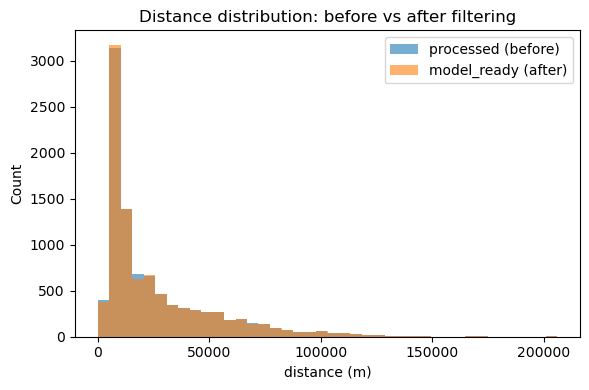

In [19]:
# Compare distance distribution before vs after (evidence for filtering effect)
plt.figure(figsize=(6, 4))
plt.hist(df["distance"], bins=40, alpha=0.6, label="processed (before)")
plt.hist(df_model["distance"], bins=40, alpha=0.6, label="model_ready (after)")
plt.title("Distance distribution: before vs after filtering")
plt.xlabel("distance (m)")
plt.ylabel("Count")
plt.legend()
savefig("22_distance_before_after.png")
plt.show()


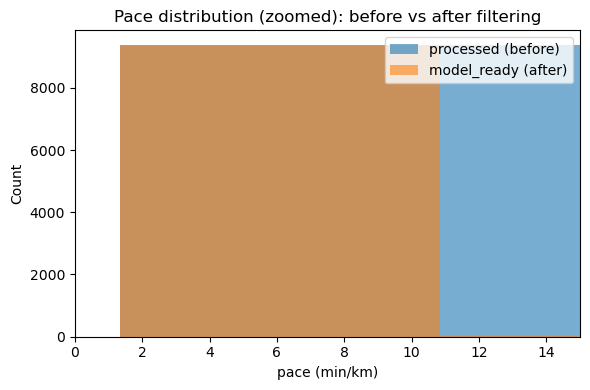

In [21]:
plt.figure(figsize=(6, 4))
plt.hist(df["pace_min_per_km"].dropna(), bins=60, alpha=0.6, label="processed (before)")
plt.hist(df_model["pace_min_per_km"].dropna(), bins=60, alpha=0.6, label="model_ready (after)")
plt.xlim(0, 15)  # Zoom: typische Rad-Pace liegt grob im einstelligen Bereich
plt.title("Pace distribution (zoomed): before vs after filtering")
plt.xlabel("pace (min/km)")
plt.ylabel("Count")
plt.legend()
savefig("23_pace_before_after_zoom.png")
plt.show()


### Scope-Definition für die Modellierung

Zusätzlich zur Entfernung klarer Artefakte (sehr kleine Distanzen) wird für die Modellierung auf **Fahrten mit distance ≥ 5 km** fokussiert.
Diese Einschränkung reduziert den Einfluss sehr kurzer Aktivitäten, die häufig untypisch sind (z. B. Abbrüche, Tests, sehr kurze Wege).

Hinweis: Hohe `stop_ratio`-Werte werden nicht gefiltert, sondern weiterhin als Sonderfälle markiert.


In [25]:
preprocess_steps = []

def log_step(name: str, before: int, after: int) -> None:
    preprocess_steps.append({
        "step": name,
        "rows_before": before,
        "rows_after": after,
        "rows_removed": before - after,
        "removed_pct": (before - after) / before * 100 if before else 0.0
    })

df_model = df.copy()

# Step 1: remove artifacts (distance >= 100 m)
before = len(df_model)
df_model = df_model[df_model["distance"] >= 100].copy()
log_step("filter_distance_ge_100m", before, len(df_model))

# Step 2: scope filter for modeling (distance >= 5 km)
before = len(df_model)
df_model = df_model[df_model["distance"] >= 5000].copy()
log_step("scope_distance_ge_5km", before, len(df_model))

report = pd.DataFrame(preprocess_steps)
display(report)
report.to_csv(PATH_DERIVED / "16_preprocessing_report.csv", index=False)

df_model.to_csv(PATH_MODEL_READY, index=False)
print("Saved model-ready dataset:", df_model.shape)
print("Path:", PATH_MODEL_READY)


,step,rows_before,rows_after,rows_removed,removed_pct
0,filter_distance_ge_100m,9410,9367,43,0.456961
1,scope_distance_ge_5km,9367,9039,328,3.501655


Saved model-ready dataset: (9039, 10)
Path: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/model_ready.csv


In [26]:
qc_model_ready = pd.DataFrame([{
    "n_rows_model_ready": len(df_model),
    "stop_ratio_gt_0_5": int((df_model["stop_ratio"] > 0.5).sum()),
    "stop_ratio_gt_0_8": int((df_model["stop_ratio"] > 0.8).sum()),
    "avg_speed_gt_45": int((df_model["avg_speed_implied_kmh"] > 45).sum()),
}])

display(qc_model_ready)
qc_model_ready.to_csv(PATH_DERIVED / "17_qc_counts_model_ready.csv", index=False)


,n_rows_model_ready,stop_ratio_gt_0_5,stop_ratio_gt_0_8,avg_speed_gt_45
0,9039,238,38,0


## Finaler Output: `model_ready.csv`

Für die nachfolgende Modellierung wird ein **modellfähiger Datensatz** erzeugt:

1. **Artefakt-Filter:** `distance >= 100 m`  
   → entfernt offensichtlich unbrauchbare Kurzaktivitäten (z. B. 0–99 m), die zu undefinierten/extremen Kennzahlen führen.

2. **Scope-Filter (Modellierungsfokus):** `distance >= 5 km`  
   → Fokus auf “echte” Fahrten; reduziert den Einfluss sehr kurzer Aktivitäten, die häufig untypisch sind.

**Wichtig:** Hohe Stop-Anteile (`stop_ratio`) werden **nicht** gefiltert, sondern als Sonderfälle beibehalten und später in der Modellierung gezielt überprüft.


## Preprocessing (Kurzfassung)

- `moving_time` ist die Zeit, in der tatsächlich gefahren wurde (ohne Pausen).
- `elapsed_time` ist die gesamte aufgezeichnete Zeit (inklusive Pausen).
- Daraus haben wir die **Stop-Zeit** berechnet: `stop_time = elapsed_time - moving_time`.
- Und den **Stop-Anteil**: `stop_ratio = stop_time / elapsed_time`.
  - Beispiel: `stop_ratio = 0.8` bedeutet: **80%** der Gesamtzeit war Standzeit/Pause.

Danach haben wir nur zwei klare Regeln für den Modellierungsdatensatz gesetzt:
- Fahrten müssen mindestens **100 m** haben (Artefakte entfernen).
- Für die Modellierung fokussieren wir uns auf Fahrten ab **5 km** (Scope-Definition).
